In [3]:

import requests
import pandas as pd
import json
import numpy as np
import os


# Setup pitch and plot
from mplsoccer.pitch import Pitch ,VerticalPitch

# username = "XXX"
# password = "XXX"


# from skillcorner.client import SkillcornerClient
# client=SkillcornerClient(username=username,password=password)

def time_to_seconds(time_str):
    if time_str is None:
        return 90 * 60  # 120 minutes = 7200 seconds
    h, m, s = map(int, time_str.split(':'))
    return h * 3600 + m * 60 + s


# 1.0 Extract the tracking data

In [13]:
####-----------------------------------------------------------------------------------
# If you're a skillcorner client and you know your match_id you can use the pyton client
###------------------------------------------------------------------------------------
# match_id=1886347
# client.save_match_tracking_data(match_id,
#                                 params={'data_version':3},
#                                 filepath=f'{match_id}_tracking_raw.jsonl')

####-----------------------------------------------------------------------------------
# If you've cloned the repo and are in your local copy
###------------------------------------------------------------------------------------
# match_id = 1886347
# raw_data = pd.read_json(f"../../data/matches/{match_id}/{match_id}_tracking_extrapolated.jsonl", lines=True))

####-----------------------------------------------------------------------------------
# If you're on a separate project/environemnt
###------------------------------------------------------------------------------------

matches_json_path = os.path.join(os.getcwd(), "data/matches.json")

with open(matches_json_path, "r") as f:
    matches_json = json.load(f)

match_id = matches_json[0]["id"]

# # Construct the raw GitHub URL
tracking_data_github_url=f'https://media.githubusercontent.com/media/SkillCorner/opendata/741bdb798b0c1835057e3fa77244c1571a00e4aa/data/matches/{match_id}/{match_id}_tracking_extrapolated.jsonl' # Data is stored using GitLFS
raw_data=pd.read_json(tracking_data_github_url,lines=True)


raw_df = pd.json_normalize(
    raw_data.to_dict("records"),
    "player_data",
    ["frame", "timestamp", "period", "possession", "ball_data"],
)

# Extract 'player_id' and 'group from the 'possession' dictionary
raw_df["possession_player_id"] = raw_df["possession"].apply(
    lambda x: x.get("player_id")
)
raw_df["possession_group"] = raw_df["possession"].apply(lambda x: x.get("group"))


# (Optional) Expand the ball_data with json_normalize
raw_df[["ball_x", "ball_y", "ball_z", "is_detected_ball"]] = pd.json_normalize(
    raw_df.ball_data
)


# (Optional) Drop the original 'possession' column if you no longer need it
raw_df = raw_df.drop(columns=["possession", "ball_data"])

# Add the match_id identifier to your dataframe
raw_df["match_id"] = match_id
tracking_df = raw_df.copy()
tracking_df.head()

,x,y,player_id,is_detected,frame,timestamp,period,possession_player_id,possession_group,ball_x,ball_y,ball_z,is_detected_ball,match_id
0,-38.16,1.51,51678,False,2510,2025-10-16,1.0,NaN,None,-0.46,-0.12,0.14,True,2017461
1,-20.78,3.31,51013,True,2510,2025-10-16,1.0,NaN,None,-0.46,-0.12,0.14,True,2017461
2,-20.93,14.81,51685,True,2510,2025-10-16,1.0,NaN,None,-0.46,-0.12,0.14,True,2017461
3,-21.03,-8.49,800322,True,2510,2025-10-16,1.0,NaN,None,-0.46,-0.12,0.14,True,2017461
4,-8.60,23.72,811820,True,2510,2025-10-16,1.0,NaN,None,-0.46,-0.12,0.14,True,2017461


We have now loaded the tracking data

# 2.0 Extract meta data from matches

In [14]:
####-----------------------------------------------------------------------------------
# If you're a skillcorner client and you know your match_id you can use the python client
###------------------------------------------------------------------------------------
# match_id=1886347
# raw_match_data=client.get_match(match_id)


####-----------------------------------------------------------------------------------
# If you've cloned the repo and are in your local copy
###------------------------------------------------------------------------------------
# match_id = 1886347
# file_path = f"../../data/matches/{match_id}/{match_id}_match.json"

# with open(file_path, "r") as f:
#     raw_match_data = json.load(f)

####-----------------------------------------------------------------------------------
# If you're on a separate project/environemnt
###------------------------------------------------------------------------------------
# match_id=1886347
meta_data_github_url=f'https://raw.githubusercontent.com/SkillCorner/opendata/741bdb798b0c1835057e3fa77244c1571a00e4aa/data/matches/{match_id}/{match_id}_match.json'
# # Read the JSON data as a JSON object
response = requests.get(meta_data_github_url)
raw_match_data = response.json()


# The output has nested json elements. We process them
raw_match_df = pd.json_normalize(raw_match_data, max_level=2)
raw_match_df["home_team_side"] = raw_match_df["home_team_side"].astype(str)

players_df = pd.json_normalize(
    raw_match_df.to_dict("records"),
    record_path="players",
    meta=[
        "home_team_score",
        "away_team_score",
        "date_time",
        "home_team_side",
        "home_team.name",
        "home_team.id",
        "away_team.name",
        "away_team.id",
    ],  # data we keep
)


# Take only players who played and create their total time
players_df = players_df[
    ~((players_df.start_time.isna()) & (players_df.end_time.isna()))
]
players_df["total_time"] = players_df["end_time"].apply(time_to_seconds) - players_df[
    "start_time"
].apply(time_to_seconds)

# Create a flag for GK
players_df["is_gk"] = players_df["player_role.acronym"] == "GK"

# Add a flag if the given player is home or away
players_df["match_name"] = (
    players_df["home_team.name"] + " vs " + players_df["away_team.name"]
)


# Add a flag if the given player is home or away
players_df["home_away_player"] = np.where(
    players_df.team_id == players_df["home_team.id"], "Home", "Away"
)

# Create flag from player
players_df["team_name"] = np.where(
    players_df.team_id == players_df["home_team.id"],
    players_df["home_team.name"],
    players_df["away_team.name"],
)

# Figure out sides
players_df[["home_team_side_1st_half", "home_team_side_2nd_half"]] = (
    players_df["home_team_side"]
    .astype(str)
    .str.strip("[]")
    .str.replace("'", "")
    .str.split(", ", expand=True)
)
# Clean up sides
players_df["direction_player_1st_half"] = np.where(
    players_df.home_away_player == "Home",
    players_df.home_team_side_1st_half,
    players_df.home_team_side_2nd_half,
)
players_df["direction_player_2nd_half"] = np.where(
    players_df.home_away_player == "Home",
    players_df.home_team_side_2nd_half,
    players_df.home_team_side_1st_half,
)


# Clean up and keep the columns that we want to keep about

columns_to_keep = [
    "start_time",
    "end_time",
    "match_name",
    "date_time",
    "home_team.name",
    "away_team.name",
    "id",
    "short_name",
    "number",
    "team_id",
    "team_name",
    "player_role.position_group",
    "total_time",
    "player_role.name",
    "player_role.acronym",
    "is_gk",
    "direction_player_1st_half",
    "direction_player_2nd_half",
]
players_df = players_df[columns_to_keep]
players_df.head()

,start_time,end_time,match_name,date_time,home_team.name,away_team.name,id,short_name,number,team_id,team_name,player_role.position_group,total_time,player_role.name,player_role.acronym,is_gk,direction_player_1st_half,direction_player_2nd_half
0,01:23:12,None,Melbourne Victory Football Club vs Auckland FC,2025-05-17T09:35:00Z,Melbourne Victory Football Club,Auckland FC,795521,A. Badolato,23,868,Melbourne Victory Football Club,Wide Attacker,408,Right Winger,RW,False,left_to_right,right_to_left
1,01:02:21,None,Melbourne Victory Football Club vs Auckland FC,2025-05-17T09:35:00Z,Melbourne Victory Football Club,Auckland FC,965685,L. Gillion,14,4177,Auckland FC,Wide Attacker,1659,Left Winger,LW,False,right_to_left,left_to_right
2,01:14:54,None,Melbourne Victory Football Club vs Auckland FC,2025-05-17T09:35:00Z,Melbourne Victory Football Club,Auckland FC,31147,T. Smith,5,4177,Auckland FC,Central Defender,906,Center Back,CB,False,right_to_left,left_to_right
3,00:00:00,01:23:12,Melbourne Victory Football Club vs Auckland FC,2025-05-17T09:35:00Z,Melbourne Victory Football Club,Auckland FC,50955,N. Velupillay,17,868,Melbourne Victory Football Club,Wide Attacker,4992,Left Winger,LW,False,left_to_right,right_to_left
4,00:00:00,01:19:39,Melbourne Victory Football Club vs Auckland FC,2025-05-17T09:35:00Z,Melbourne Victory Football Club,Auckland FC,23418,F. Gallegos,28,4177,Auckland FC,Midfield,4779,Left Midfield,LM,False,right_to_left,left_to_right


Metadata is now ready !

# 3.0 Merge Dataframes

In [15]:
# Merging datasets
enriched_tracking_data = tracking_df.merge(
    players_df, left_on=["player_id"], right_on=["id"]
)
enriched_tracking_data.head()

,x,y,player_id,is_detected,frame,timestamp,period,possession_player_id,possession_group,ball_x,...,number,team_id,team_name,player_role.position_group,total_time,player_role.name,player_role.acronym,is_gk,direction_player_1st_half,direction_player_2nd_half
0,-38.16,1.51,51678,False,2510,2025-10-16,1.0,NaN,None,-0.46,...,25,868,Melbourne Victory Football Club,Other,5400,Goalkeeper,GK,True,left_to_right,right_to_left
1,-20.78,3.31,51013,True,2510,2025-10-16,1.0,NaN,None,-0.46,...,5,868,Melbourne Victory Football Club,Central Defender,3469,Right Center Back,RCB,False,left_to_right,right_to_left
2,-20.93,14.81,51685,True,2510,2025-10-16,1.0,NaN,None,-0.46,...,4,868,Melbourne Victory Football Club,Central Defender,5400,Left Center Back,LCB,False,left_to_right,right_to_left
3,-21.03,-8.49,800322,True,2510,2025-10-16,1.0,NaN,None,-0.46,...,16,868,Melbourne Victory Football Club,Full Back,5400,Right Back,RB,False,left_to_right,right_to_left
4,-8.60,23.72,811820,True,2510,2025-10-16,1.0,NaN,None,-0.46,...,28,868,Melbourne Victory Football Club,Full Back,5400,Left Back,LB,False,left_to_right,right_to_left


Our tracking data is now ready !

---

# 4.0 READ DYNAMIC EVENT FILE AND ISOLATE ONE EVENT

In [22]:
# match_id = 1886347
url = f"https://raw.githubusercontent.com/SkillCorner/opendata/master/data/matches/{match_id}/{match_id}_dynamic_events.csv"
de_match = pd.read_csv(url)


C:\Users\g4a4b\AppData\Local\Temp\ipykernel_5552\2624735027.py:3: DtypeWarning: Columns (75,77,184,264) have mixed types. Specify dtype option on import or set low_memory=False.
  de_match = pd.read_csv(url)


In [23]:
# This is a run in behind
de_match[de_match.event_id == "1_2"][
    [
        "player_id",
        "frame_start",
        "frame_end",
        "event_type",
        "event_subtype",
        "team_id",
        "player_in_possession_id",
        "x_start",
        "y_start",
        "x_end",
        "y_end",
    ]
]

,player_id,frame_start,frame_end,event_type,event_subtype,team_id,player_in_possession_id,x_start,y_start,x_end,y_end
9,50955,2541,2550,off_ball_run,run_ahead_of_the_ball,868,51013.0,14.34,31.08,18.18,29.73


# 5.0 MERGE WITH TRACKING DATA ON A GIVEN FRAME MOMENT - END FOR THIS EXAMPLE

## 5.1 RUN IN BEHIND EXAMPLE

In [24]:
specific_event = de_match[de_match.event_id == "1_2"][
    [
        "player_id",
        "frame_start",
        "frame_end",
        "event_type",
        "team_id",
        "player_in_possession_id",
        "x_start",
        "y_start",
        "x_end",
        "y_end",
    ]
]

synced = specific_event.merge(
    enriched_tracking_data,
    left_on=["frame_end"],
    right_on="frame",
    suffixes=("_event", "_tracking"),
)

synced["runner"] = synced.player_id_event == synced.player_id_tracking
synced["ball_carrier"] = synced.player_in_possession_id == synced.player_id_tracking
synced["tip"] = synced.team_id_event == synced.team_id_tracking

synced.head()

,player_id_event,frame_start,frame_end,event_type,team_id_event,player_in_possession_id,x_start,y_start,x_end,y_end,...,player_role.position_group,total_time,player_role.name,player_role.acronym,is_gk,direction_player_1st_half,direction_player_2nd_half,runner,ball_carrier,tip
0,50955,2541,2550,off_ball_run,868,51013.0,14.34,31.08,18.18,29.73,...,Other,5400,Goalkeeper,GK,True,left_to_right,right_to_left,False,False,True
1,50955,2541,2550,off_ball_run,868,51013.0,14.34,31.08,18.18,29.73,...,Central Defender,3469,Right Center Back,RCB,False,left_to_right,right_to_left,False,True,True
2,50955,2541,2550,off_ball_run,868,51013.0,14.34,31.08,18.18,29.73,...,Central Defender,5400,Left Center Back,LCB,False,left_to_right,right_to_left,False,False,True
3,50955,2541,2550,off_ball_run,868,51013.0,14.34,31.08,18.18,29.73,...,Full Back,5400,Right Back,RB,False,left_to_right,right_to_left,False,False,True
4,50955,2541,2550,off_ball_run,868,51013.0,14.34,31.08,18.18,29.73,...,Full Back,5400,Left Back,LB,False,left_to_right,right_to_left,False,False,True


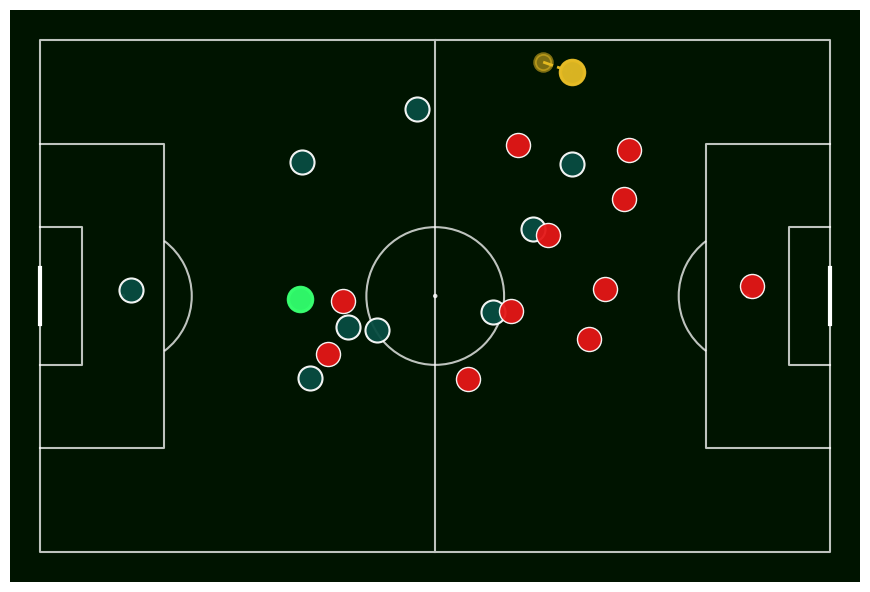

In [25]:
synced["runner"] = synced.player_id_event == synced.player_id_tracking
synced["ball_carrier"] = synced.player_in_possession_id == synced.player_id_tracking
synced["tip"] = synced.team_id_event == synced.team_id_tracking

pitch = Pitch(
    pitch_type="skillcorner",
    line_alpha=0.75,
    pitch_length=105,
    pitch_width=68,
    pitch_color="#001400",
    line_color="white",
    linewidth=1.5,
)
fig, ax = pitch.grid(figheight=8, endnote_height=0, title_height=0)

size = 300
possession_team = synced[synced.tip == True]
ax.scatter(
    possession_team["x"],
    possession_team["y"],
    c="#084D42",
    alpha=0.95,
    s=size,
    edgecolors="white",
    linewidths=1.5,
    zorder=10,
    label="team",
)

out_of_possession_team = synced[synced.tip == False]
ax.scatter(
    out_of_possession_team["x"],
    out_of_possession_team["y"],
    c="#E51717",
    alpha=0.95,
    s=size,
    edgecolors="white",
    linewidths=1,
    zorder=10,
    label="team",
)

runner = synced[synced.runner == True]
ax.scatter(
    runner["x"],
    runner["y"],
    c="#E5BA21",
    alpha=0.95,
    s=size,
    edgecolors="#E5BA21",
    linewidths=2.5,
    zorder=10,
    label="team",
)

# Running
ax.plot(
    [runner["x_start"], runner["x"]],
    [runner["y_start"], runner["y"]],
    color="#E5BA21",
    linewidth=2,
    ls="--",
)

ax.scatter(
    runner["x_start"],
    runner["y_start"],
    c="#E5BA21",
    alpha=0.55,
    s=size / 2,
    edgecolors="#E5BA21",
    linewidths=2.5,
    zorder=10,
    label="team",
)


ball_carrier = synced[synced.ball_carrier == True]
ax.scatter(
    ball_carrier["x"],
    ball_carrier["y"],
    c="#32FE6B",
    alpha=0.95,
    s=size,
    edgecolors="#32FE6B",
    linewidths=2.5,
    zorder=10,
    label="team",
)

## 5.2 UNDERLAP EXAMPLE

### FIND UNDERLAPS

In [26]:
de_match[de_match.event_subtype == "underlap"][
    ["event_id", "team_id", "distance_covered", "x_start", "y_start", "x_end", "y_end"]
].head()

,event_id,team_id,distance_covered,x_start,y_start,x_end,y_end
96,1_11,4177,41.88,-15.99,13.93,25.72,21.64
644,1_61,4177,26.06,9.58,16.31,35.66,18.32
1032,1_106,868,3.47,38.77,17.96,42.19,17.36
1392,1_157,4177,15.93,28.23,22.85,43.87,20.14
1583,1_185,4177,6.79,13.10,-32.45,19.76,-29.80


### MERGE AND VISUALIZE

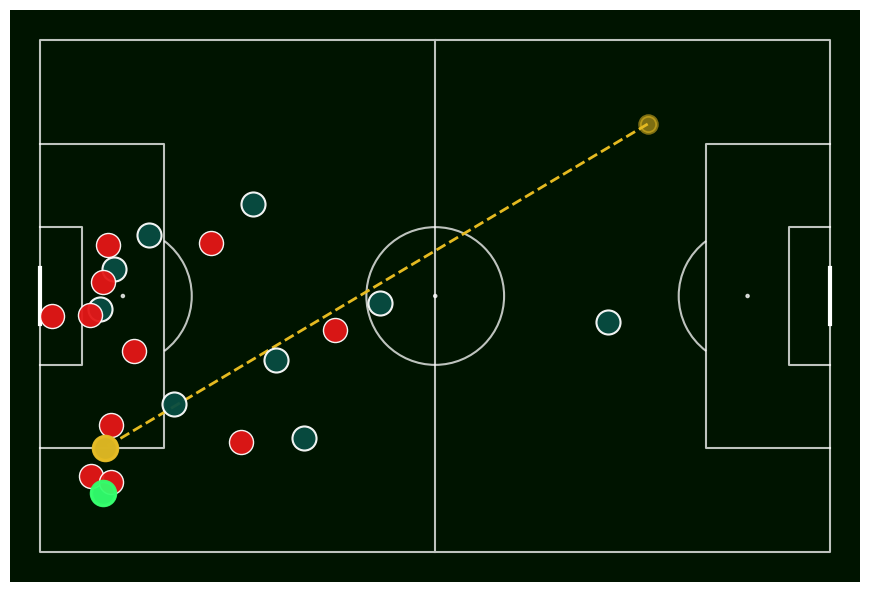

In [30]:
# ISOLATE END FRAME OF THE RUN
synced = de_match[de_match.event_id == "1_157"].merge(
    enriched_tracking_data,
    left_on=["frame_end"],
    right_on="frame",
    suffixes=("_event", "_tracking"),
)


# PREPARE ASSETS TO HIGHLIGHT: RUNNER, BALL CARRIER. TEAM IN POSSESSION
synced["runner"] = synced.player_id_event == synced.player_id_tracking
synced["ball_carrier"] = synced.player_in_possession_id == synced.player_id_tracking
synced["tip"] = synced.team_id_event == synced.team_id_tracking


# PLOT PITCH
pitch = Pitch(
    pitch_type="skillcorner",
    line_alpha=0.75,
    pitch_length=105,
    pitch_width=68,
    pitch_color="#001400",
    line_color="white",
    linewidth=1.5,
)
fig, ax = pitch.grid(figheight=8, endnote_height=0, title_height=0)

size = 300

# ADD EACH LAYER

## ADD TEAM IN POSSESSION
possession_team = synced[synced.tip == True]
ax.scatter(
    possession_team["x"],
    possession_team["y"],
    c="#084D42",
    alpha=0.95,
    s=size,
    edgecolors="white",
    linewidths=1.5,
    zorder=10,
    label="team",
)

## ADD TEAM OUT OF POSSESSION
out_of_possession_team = synced[synced.tip == False]
ax.scatter(
    out_of_possession_team["x"],
    out_of_possession_team["y"],
    c="#E51717",
    alpha=0.95,
    s=size,
    edgecolors="white",
    linewidths=1,
    zorder=10,
    label="team",
)

## ADD RUNNER
runner = synced[synced.runner == True]
ax.scatter(
    runner["x"],
    runner["y"],
    c="#E5BA21",
    alpha=0.95,
    s=size,
    edgecolors="#E5BA21",
    linewidths=2.5,
    zorder=10,
    label="team",
)

# ADD RUNNER'S ORIGIN POINT AND LINE (NOT TRAJECTORY)
ax.plot(
    [runner["x_start"], runner["x"]],
    [runner["y_start"], runner["y"]],
    color="#E5BA21",
    linewidth=2,
    ls="--",
)


ax.scatter(
    runner["x_start"],
    runner["y_start"],
    c="#E5BA21",
    alpha=0.55,
    s=size / 2,
    edgecolors="#E5BA21",
    linewidths=2.5,
    zorder=10,
    label="team",
)


# HIGHLIGHT BALL CARRIER
ball_carrier = synced[synced.ball_carrier == True]
ax.scatter(
    ball_carrier["x"],
    ball_carrier["y"],
    c="#32FE6B",
    alpha=0.95,
    s=size,
    edgecolors="#32FE6B",
    linewidths=2.5,
    zorder=10,
    label="team",
)